<a href="https://colab.research.google.com/github/kurasaiteja/Whatsapp-Analysis/blob/master/Whatsapp_Group_Chat_Analysis_for_iOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve 5 steps. The first step is Data Collection. In this case Data collection involves

Opening Whatsapp group chat.
Go to Settings.
Click on Export Chat.
Click on without media.

In [110]:
!pip install emoji

In [111]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [112]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 5853 (delta 85), reused 118 (delta 52), pack-reused 5667
Receiving objects: 100% (5853/5853), 107.06 MiB | 13.35 MiB/s, done.
Resolving deltas: 100% (3420/3420), done.
/content/word_cloud/word_cloud/word_cloud/word_cloud
Processing /content/word_cloud/word_cloud/word_cloud/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post90+gbda4195-cp36-cp36m-linux_x86_64.whl size=338624 sha256=ced3d23d2e9c96ce7a052f954f659f648b2ffc41eca2f093ddfb96681af4f519
  Stored in directory: /tmp/pip-ephem-wheel-cache-kuqr5p3l/wheels/4a/a2/76/e7f6c5039f8f8c93c078f38cedf6c90ee95019d9483f181ed7
Successfully built wordcloud
  Found existing installation: wordcloud 1.6.0.post90+gbda4195
    Uninstalling wordcloud-1.6.0.post90+gbda4195:
      Successfully uninstalled wordcloud-1.6.0.post90+gbda4195


# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






In [113]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [114]:
startsWithDateAndTime("[07-03-19 6:46:53] Gowth Bhuj: Ok")

True

In [115]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [116]:
def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message


In [117]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/_chat 2.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

### If date time is in format Day-Month-year run this code.

In [118]:
import datetime
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

In [119]:
df.head(2)

,Date,Time,Author,Message
0,2019-03-07,6:45:58 PM,Aakarsh Yelisetty,Adhe chedham aa inka?
1,2019-03-07,6:46:15 PM,Gowtham Vce,Emaina ideas unte chep


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35088 entries, 0 to 35087
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     35088 non-null  datetime64[ns]
 1   Time     35088 non-null  object        
 2   Author   35070 non-null  object        
 3   Message  35088 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.1+ MB


## Printing Participants

In [121]:
df.Author.unique()

array(['Aakarsh Yelisetty', 'Gowtham Vce', 'Vishal Vce', 'Sai Teja', None,
       'Manikanta'], dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



Let us remove the messages created by None

In [122]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35070 entries, 0 to 35087
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     35070 non-null  datetime64[ns]
 1   Time     35070 non-null  object        
 2   Author   35070 non-null  object        
 3   Message  35070 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.3+ MB


In [123]:
df.Author.unique()

array(['Aakarsh Yelisetty', 'Gowtham Vce', 'Vishal Vce', 'Sai Teja',
       'Manikanta'], dtype=object)

We successfully removed None author.

# Group Wise Stats.

In [124]:
total_messages = df.shape[0]
print(total_messages)

35070


Let us now find out the total Media Messages

In [125]:
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print(media_messages)

361


In [126]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

In [127]:
emojis = sum(df['emoji'].str.len())
print(emojis)

6572


In [128]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [129]:
links = np.sum(df.urlcount)

In [130]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 35070
Media: 361
Emojis: 6572
Links: 254


## Let us Separate the media messages and text messages and sticker messages

In [131]:
media_messages_df = df[(df['Message'] == 'image omitted')|(df['Message'] == 'video omitted')]

In [132]:
sticker_messages_df = df[df['Message'] == 'sticker omitted']
sticker_messages_df

,Date,Time,Author,Message,emoji,urlcount
34250,2020-07-07,1:34:29 PM,Aakarsh Yelisetty,sticker omitted,[],0
34267,2020-07-07,1:45:31 PM,Vishal Vce,sticker omitted,[],0
34270,2020-07-07,2:55:59 PM,Aakarsh Yelisetty,sticker omitted,[],0
34294,2020-07-07,9:30:23 PM,Vishal Vce,sticker omitted,[],0
34304,2020-07-07,9:50:03 PM,Sai Teja,sticker omitted,[],0
...,...,...,...,...,...,...
35059,2020-07-10,1:10:38 AM,Manikanta,sticker omitted,[],0
35070,2020-07-10,1:13:46 AM,Gowtham Vce,sticker omitted,[],0
35073,2020-07-10,1:14:09 AM,Gowtham Vce,sticker omitted,[],0
35076,2020-07-10,1:14:43 AM,Gowtham Vce,sticker omitted,[],0


In [133]:
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)

In [134]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34624 entries, 0 to 35087
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      34624 non-null  datetime64[ns]
 1   Time      34624 non-null  object        
 2   Author    34624 non-null  object        
 3   Message   34624 non-null  object        
 4   emoji     34624 non-null  object        
 5   urlcount  34624 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.8+ MB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [135]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [136]:
messages_df.tail(2)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
35086,2020-07-10,12:23:09 PM,Sai Teja,Bathuku gurinchi cheptadu,[],0,25,3,1
35087,2020-07-10,12:33:04 PM,Vishal Vce,Yo chusta,[],0,9,2,1


In [137]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [138]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  #sticker conists of stickers messages
  stickers = sticker_messages_df[sticker_messages_df['Author'] == l[i]].shape[0]
  print('Sticker Messages Sent', stickers)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Aakarsh Yelisetty -
Messages Sent 5615
Words per message 3.8016028495102403
Media Messages Sent 78
Sticker Messages Sent 22
Emojis Sent 1370
Links Sent 79

Stats of Gowtham Vce -
Messages Sent 5997
Words per message 2.836251459062865
Media Messages Sent 31
Sticker Messages Sent 15
Emojis Sent 1817
Links Sent 15

Stats of Vishal Vce -
Messages Sent 9699
Words per message 3.3620991854830393
Media Messages Sent 33
Sticker Messages Sent 31
Emojis Sent 1408
Links Sent 55

Stats of Sai Teja -
Messages Sent 7821
Words per message 3.9914333205472445
Media Messages Sent 152
Sticker Messages Sent 13
Emojis Sent 800
Links Sent 54

Stats of Manikanta -
Messages Sent 5492
Words per message 4.2731245447924255
Media Messages Sent 70
Sticker Messages Sent 1
Emojis Sent 1177
Links Sent 51



In [139]:
messages_df=messages_df[messages_df["urlcount"]==0]

# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [140]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

178


### Most used emoji

In [141]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 2682), ('🤣', 1431), ('\U0001f97a', 384), ('😒', 208), ('🔥', 79), ('🙄', 78), ('😞', 64), ('🤦🏻\u200d♂️', 61), ('\U0001f973', 61), ('🤕', 53), ('🤙🏻', 46), ('😮', 45), ('😪', 44), ('🙂', 44), ('😭', 43), ('😢', 43), ('🤧', 40), ('🤦🏻\u200d♂', 37), ('😅', 35), ('😨', 34), ('😕', 34), ('😔', 34), ('😏', 31), ('🙃', 29), ('😎', 29), ('😱', 28), ('\U0001f975', 26), ('🤥', 26), ('🤢', 23), ('🙏', 23), ('☹️', 23), ('💥', 23), ('\U0001f92f', 22), ('\U0001f928', 20), ('😖', 19), ('👏🏻', 18), ('😣', 18), ('😆', 18), ('😑', 17), ('🙏🏻', 17), ('😁', 16), ('😟', 16), ('🤷🏻\u200d♂️', 16), ('👍🏻', 16), ('😳', 15), ('🍃', 14), ('\U0001f974', 13), ('😲', 13), ('\U0001f929', 11), ('🍻', 11), ('\U0001f971', 11), ('😤', 10), ('🕺🏻', 10), ('\U0001f970', 10), ('😍', 10), ('😐', 9), ('😓', 9), ('😴', 9), ('🤔', 8), ('👀', 8), ('\U0001f92e', 8), ('👍', 8), ('\U0001f9d0', 8), ('🤷🏻\u200d♂', 8), ('😦', 8), ('\U0001f92d', 7), ('🤐', 7), ('😶', 7), ('😬', 7), ('😡', 7), ('👗', 7), ('😵', 7), ('🙁', 7), ('\U0001f9b8\u200d♂️', 7), ('💯', 7), ('🙆🏻\u200d♂', 6), ('😹',

In [142]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,2682
1,🤣,1431
2,🥺,384
3,😒,208
4,🔥,79
...,...,...
173,👋,1
174,😗,1
175,🍀,1
176,🖕🏻,1


We can see '😂 '   dominates the list.

### Emoji distribution visualisation

In [143]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [144]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Aakarsh Yelisetty


Emoji Distribution for Gowtham Vce


Emoji Distribution for Vishal Vce


Emoji Distribution for Sai Teja


Emoji Distribution for Manikanta


# Some more Stats

### **Day wise Distribution**

In [145]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [146]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [147]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [148]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

### **When are the group members most active?**

Text(0, 0.5, 'Time')

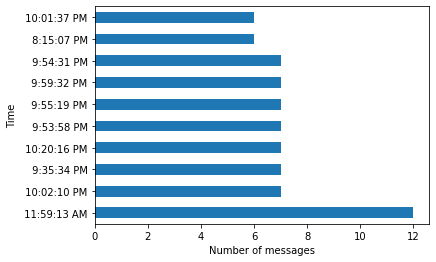

In [149]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

### **The most happening day was -**

2019-07-26    720
2020-06-26    461
2019-08-18    434
2020-04-06    432
2019-08-12    409
             ... 
2019-09-09      1
2019-11-03      1
2019-04-15      1
2019-04-28      1
2019-06-05      1
Name: Date, Length: 390, dtype: int64


Text(0, 0.5, 'Date')

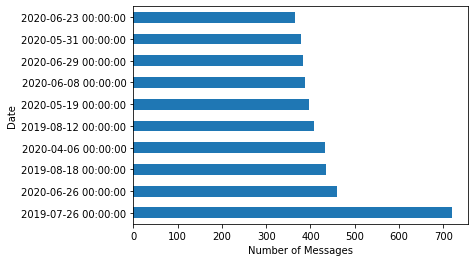

In [150]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### **The early bird**

### The Late Owl

### **Message Having Maximum number of words**

In [151]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2019-04-25 00:00:00
Time                                                   9:59:12 PM
Author                                          Aakarsh Yelisetty
Message         Hello IT III Year, Section A-B students,  Plea...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                 2703
Word_Count                                                    497
MessageCount                                                    1
emojicount                                                      0
Name: 1259, dtype: object

### **Word Cloud**

In [152]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 714127 words in all the messages.


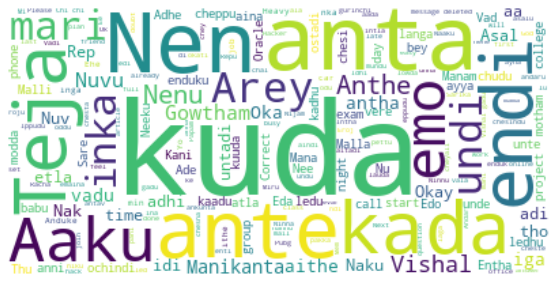

In [153]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

### **Author wise WordCloud**

In [154]:
# l = messages_df.Author.unique()
# for i in range(len(l)):
#   dummy_df = messages_df[messages_df['Author'] == l[i]]
#   text = " ".join(review for review in dummy_df.Message)
#   stopwords = set(STOPWORDS)
#   stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
#   # Generate a word cloud image
#   print('Author name',l[i])
#   wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
#   # Display the generated image:
#   # the matplotlib way:
  
#   plt.figure( figsize=(10,5))
#   plt.imshow(wordcloud, interpolation='bilinear')
#   plt.axis("off")
#   plt.show()